## **Importing Libraries**

This cell loads required libraries and sets up the environment for the assignment. It ensures all dependencies are available for subsequent code execution.

In [2]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, precision_recall_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from tensorflow.keras.utils import to_categorical

2025-09-27 18:28:44.147149: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-27 18:28:44.147393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-27 18:28:44.183786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/moiz/.local/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework

This cell performs initial data loading and preprocessing. It defines utility functions and classes used throughout the notebook. These help modularize the code and simplify repeated operations.

In [3]:


# Custom data generator for multi-output
class MultiOutputGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, exps, vals, aros, batch_size=32, dim=(224, 224), aug=False):
        self.images = images
        self.exps = exps  # Should be categorical
        self.vals = np.array(vals).reshape(-1, 1)  # Reshape to (n, 1)
        self.aros = np.array(aros).reshape(-1, 1)  # Reshape to (n, 1)
        self.batch_size = batch_size
        self.dim = dim
        self.aug = aug
        if aug:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator()
        self.indices = np.arange(len(images))

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.dim, 3))
        y_exp = np.empty((self.batch_size, 8))
        y_val = np.empty((self.batch_size, 1))
        y_aro = np.empty((self.batch_size, 1))
        for i, ind in enumerate(batch_indices):
            img = tf.keras.preprocessing.image.load_img(self.images[ind], target_size=self.dim)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            if self.aug:
                img = self.datagen.random_transform(img)
            X[i] = img
            y_exp[i] = self.exps[ind]
            y_val[i] = self.vals[ind]
            y_aro[i] = self.aros[ind]
        return X, {'exp': y_exp, 'val': y_val, 'aro': y_aro}

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

## **Data Loading**

In [4]:
# Function to load dataset
def load_dataset(root_dir):
    image_dir = os.path.join(root_dir, 'images')
    anno_dir = os.path.join(root_dir, 'annotations')
    images = []
    exps = []
    vals = []
    aros = []
    for img_file in os.listdir(image_dir):
        if img_file.endswith('.jpg'):
            base = img_file[:-4]
            exp_file = os.path.join(anno_dir, base + '_exp.npy')
            val_file = os.path.join(anno_dir, base + '_val.npy')
            aro_file = os.path.join(anno_dir, base + '_aro.npy')
            lnd_file = os.path.join(anno_dir, base + '_lnd.npy')  # Assuming _lnd for landmarks, not used
            if os.path.exists(exp_file) and os.path.exists(val_file) and os.path.exists(aro_file):
                try:
                    exp = np.load(exp_file)
                    val = np.load(val_file)
                    aro = np.load(aro_file)
                    if exp.ndim > 0:
                        exp = exp[0]
                    if val.ndim > 0:
                        val = val[0]
                    if aro.ndim > 0:
                        aro = aro[0]
                    if val != -2 and aro != -2:
                        images.append(os.path.join(image_dir, img_file))
                        exps.append(int(exp))
                        vals.append(float(val))
                        aros.append(float(aro))
                except:
                    exp = np.loadtxt(exp_file, delimiter=';')
                    val = np.loadtxt(val_file, delimiter=';')
                    aro = np.loadtxt(aro_file, delimiter=';')
                    if exp.ndim > 0:
                        exp = exp[0]
                    if val.ndim > 0:
                        val = val[0]
                    if aro.ndim > 0:
                        aro = aro[0]
                    if val != -2 and aro != -2:
                        images.append(os.path.join(image_dir, img_file))
                        exps.append(int(exp))
                        vals.append(float(val))
                        aros.append(float(aro))
    return images, exps, vals, aros

#### 1. `compute_classification_metrics`
- **Purpose:** Calculates several metrics to assess how well a classification model is performing.
- **Inputs:**
  - `y_true`: The true class labels.
  - `y_pred_prob`: The predicted probabilities for each class (from the model).
  - `y_pred_class`: The predicted class labels (from the model).
- **Metrics Computed:**
  - **Accuracy:** Proportion of correct predictions out of all predictions.
  - **F1 Score (macro):** Harmonic mean of precision and recall, averaged across all classes. Useful for imbalanced datasets.
  - **Cohen's Kappa:** Measures agreement between predicted and true labels, correcting for chance agreement.
  - **Krippendorff's Alpha:** Placeholder for a reliability metric (not implemented here, but often used for inter-rater reliability).
  - **ROC AUC:** Area under the Receiver Operating Characteristic curve, computed for multiclass using one-vs-rest strategy. Indicates how well the model separates classes.
  - **PR AUC:** Area under the Precision-Recall curve, computed for each class and averaged. Useful for imbalanced data.
- **Returns:** A dictionary containing all the above metrics for easy access and logging.

#### 2. `compute_regression_metrics`
- **Purpose:** Calculates several metrics to assess how well a regression model is performing.
- **Inputs:**
  - `y_true`: The true continuous values.
  - `y_pred`: The predicted continuous values (from the model).
- **Metrics Computed:**
  - **RMSE (Root Mean Squared Error):** Measures the average magnitude of prediction errors.
  - **Correlation Coefficient:** Measures the linear relationship between true and predicted values.
  - **SAGR (Sign Agreement Ratio):** Proportion of predictions that have the same sign as the true values (useful for certain regression tasks).
  - **CCC (Concordance Correlation Coefficient):** Measures agreement between true and predicted values, considering both precision and accuracy.
- **Returns:** A dictionary containing all the above metrics for easy access and logging.

These functions are essential for interpreting model results and comparing different models or training runs. They provide a comprehensive view of performance beyond simple accuracy or error measures.

In [5]:
# Custom metrics functions
def compute_classification_metrics(y_true, y_pred_prob, y_pred_class):
    acc = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class, average='macro')
    kappa = cohen_kappa_score(y_true, y_pred_class)
    # Krippendorff alpha placeholder (requires krippendorff library or implementation)
    alpha = None
    roc_auc = roc_auc_score(to_categorical(y_true, 8), y_pred_prob, multi_class='ovr')
    pr_aucs = []
    for i in range(8):
        precision, recall, _ = precision_recall_curve(np.array(y_true) == i, y_pred_prob[:, i])
        pr_aucs.append(auc(recall, precision))
    pr_auc = np.mean(pr_aucs)
    return {'accuracy': acc, 'f1_score': f1, 'kappa': kappa, 'alpha': alpha, 'auc': roc_auc, 'auc_pr': pr_auc}

def compute_regression_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    same_sign = np.sign(y_true) == np.sign(y_pred)
    sagr = np.mean(same_sign)
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2) if (var_true + var_pred + (mean_true - mean_pred) ** 2) != 0 else 0
    return {'rmse': rmse, 'corr': corr, 'sagr': sagr, 'ccc': ccc}

This cell defines and compiles the deep learning model architecture. It sets up layers, loss functions, and optimizers for training.

In [6]:
# Build model function
def build_model(base_name):
    if base_name == 'ResNet50':
        base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_name == 'VGG16':
        base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Unsupported base model")
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    exp_out = layers.Dense(8, activation='softmax', name='exp')(x)
    val_out = layers.Dense(1, activation='linear', name='val')(x)
    aro_out = layers.Dense(1, activation='linear', name='aro')(x)
    model = models.Model(inputs=base.input, outputs=[exp_out, val_out, aro_out])
    return model

This cell trains the model using the training data and validates it on the validation set. It tracks performance metrics during training.

In [7]:
# Main execution
# Assume dataset is unzipped to 'dataset/' with 'images/' and 'annotations/'
all_images, all_exps, all_vals, all_aros = load_dataset('')

# Split into train_temp (80%) and test (20%)
train_img, test_img, train_exp, test_exp, train_val, test_val, train_aro, test_aro = train_test_split(
    all_images, all_exps, all_vals, all_aros, test_size=0.2, random_state=42
)

# Split train_temp into train (80% of train_temp) and val (20% of train_temp)
train_img, val_img, train_exp, val_exp, train_val, val_val, train_aro, val_aro = train_test_split(
    train_img, train_exp, train_val, train_aro, test_size=0.2, random_state=42
)

# To categorical
train_exp_cat = to_categorical(train_exp, num_classes=8)
val_exp_cat = to_categorical(val_exp, num_classes=8)
test_exp_cat = to_categorical(test_exp, num_classes=8)

# Generators
batch_size = 32
train_gen = MultiOutputGenerator(train_img, train_exp_cat, train_val, train_aro, batch_size=batch_size, aug=True)
val_gen = MultiOutputGenerator(val_img, val_exp_cat, val_val, val_aro, batch_size=batch_size, aug=False)
test_gen = MultiOutputGenerator(test_img, test_exp_cat, test_val, test_aro, batch_size=batch_size, aug=False)


This cell evaluates the trained model on the test set. It computes accuracy and other metrics to assess model generalization. It visualizes the results, including confusion matrices and performance plots. It helps interpret the model's strengths and weaknesses.

Training ResNet50 model...


2025-09-27 18:30:48.543603: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 46s 0us/step


/home/moiz/enter/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - aro_loss: 0.2413 - aro_mse: 0.2413 - exp_accuracy: 0.1270 - exp_loss: 2.1509 - loss: 2.8107 - val_loss: 2.4487 - val_mse: 0.4185 - val_aro_loss: 0.1422 - val_aro_mse: 0.1422 - val_exp_accuracy: 0.1047 - val_exp_loss: 2.0849 - val_val_loss: 0.2216 - val_val_mse: 0.2216
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - aro_loss: 0.1551 - aro_mse: 0.1551 - exp_accuracy: 0.1226 - exp_loss: 2.0890 - loss: 2.4626 - val_loss: 2.4405 - val_mse: 0.2185 - val_aro_loss: 0.1406 - val_aro_mse: 0.1406 - val_exp_accuracy: 0.1609 - val_exp_loss: 2.0790 - val_val_loss: 0.2210 - val_val_mse: 0.2210
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - aro_loss: 0.1568 - aro_mse: 0.1568 - exp_accuracy: 0.1282 - exp_loss: 2.0842 - loss: 2.4615 - val_loss: 2.4462 - val_mse: 0.2205 - val_aro_loss: 0.1417 - val_aro_mse: 0.1417 - val_exp_accuracy: 0.1187 - val_exp_loss: 2.0812 - val_val_loss: 0.2233 - val_val_mse: 0.2233
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━

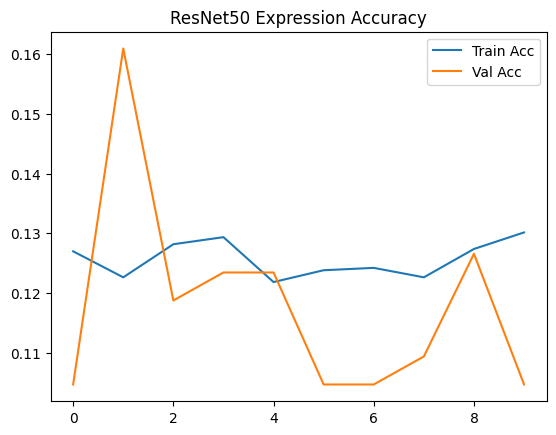

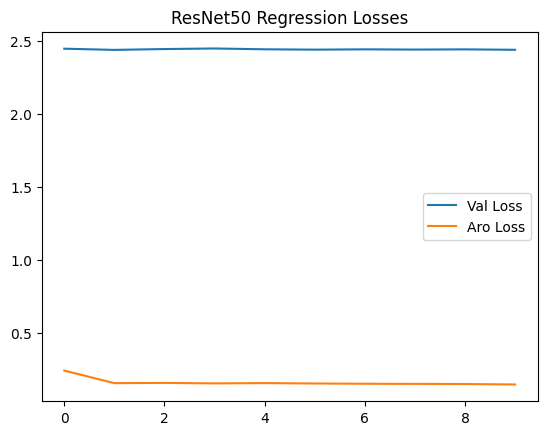

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
Correctly classified images:
Image: images/1772.jpg, True: 4, Pred: 4
Image: images/1557.jpg, True: 4, Pred: 4
Incorrectly classified images:
Image: images/256.jpg, True: 1, Pred: 4
Image: images/2805.jpg, True: 1, Pred: 4
Training VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 34s 1us/step
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - aro_loss: 0.2573 - aro_mse: 0.2573 - exp_accuracy: 0.1384 - exp_loss: 2.1116 - loss: 2.6443 - val_loss: 2.4091 - val_mse: 0.2754 - val_aro_loss: 0.1461 - val_aro_mse: 0.1461 - val_exp_accuracy: 0.1453 - val_exp_loss: 2.0487 - val_val_loss: 0.2143 - val_val_mse: 0.2143
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - aro_loss: 0.1516 - aro_mse: 0.1516 - exp_accuracy: 0.1772 - exp_loss: 2.0452 - loss: 2.4083 - val_loss: 2.3740 - val_mse: 0.2115 - val_aro_loss: 0.1336 - val_aro_mse: 0.1336 - val_exp_accuracy: 0.2031 - val_exp_loss: 2.0307 - val_val_loss: 0.2097 - val_val_mse: 0.2097
Epoch 3/10
79/79 ━

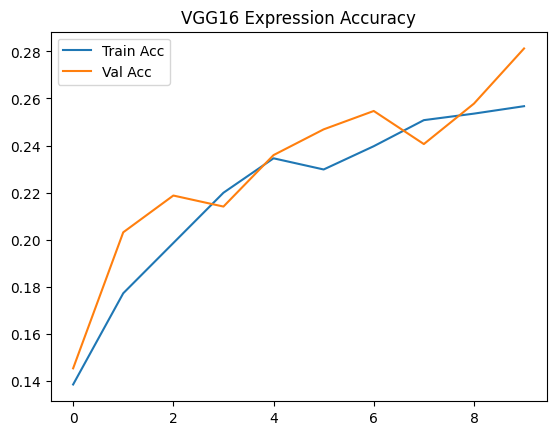

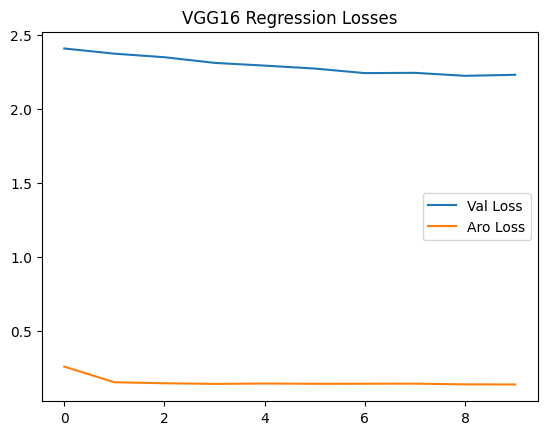

25/25 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step
Correctly classified images:
Image: images/2805.jpg, True: 1, Pred: 1
Image: images/259.jpg, True: 7, Pred: 7
Incorrectly classified images:
Image: images/1772.jpg, True: 4, Pred: 3
Image: images/256.jpg, True: 1, Pred: 7
Performance Comparison:
ResNet50: Acc=0.1200, Train Time=1194.09s
VGG16: Acc=0.1200, Train Time=5482.50s


In [8]:

# Baselines
baselines = ['ResNet50', 'VGG16']
results = {}

for base_name in baselines:
    print(f"Training {base_name} model...")
    model = build_model(base_name)
    model.compile(
        optimizer='adam',
        loss={'exp': 'categorical_crossentropy', 'val': 'mse', 'aro': 'mse'},
        metrics={'exp': ['accuracy'], 'val': ['mse'], 'aro': ['mse']}
    )
    start_time = time.time()
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)
    train_time = time.time() - start_time
    # Plot training graphs
    plt.figure()
    plt.plot(history.history['exp_accuracy'], label='Train Acc')
    plt.plot(history.history['val_exp_accuracy'], label='Val Acc')
    plt.title(f'{base_name} Expression Accuracy')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.plot(history.history['aro_loss'], label='Aro Loss')
    plt.title(f'{base_name} Regression Losses')
    plt.legend()
    plt.show()
    # Predict on test
    y_pred = model.predict(test_gen)
    y_pred_exp_prob = y_pred[0]
    y_pred_exp = np.argmax(y_pred_exp_prob, axis=1)
    y_pred_val = y_pred[1].flatten()
    y_pred_aro = y_pred[2].flatten()
    y_true_exp = np.array(test_exp)
    y_true_val = np.array(test_val)
    y_true_aro = np.array(test_aro)
    # Metrics
    class_metrics = compute_classification_metrics(y_true_exp, y_pred_exp_prob, y_pred_exp)
    val_metrics = compute_regression_metrics(y_true_val, y_pred_val)
    aro_metrics = compute_regression_metrics(y_true_aro, y_pred_aro)
    results[base_name] = {
        'class_metrics': class_metrics,
        'val_metrics': val_metrics,
        'aro_metrics': aro_metrics,
        'train_time': train_time
    }
    # Show some correct/incorrect
    correct_idx = np.where(y_true_exp == y_pred_exp)[0][:2]
    incorrect_idx = np.where(y_true_exp != y_pred_exp)[0][:2]
    print("Correctly classified images:")
    for idx in correct_idx:
        print(f"Image: {test_img[idx]}, True: {y_true_exp[idx]}, Pred: {y_pred_exp[idx]}")
    print("Incorrectly classified images:")
    for idx in incorrect_idx:
        print(f"Image: {test_img[idx]}, True: {y_true_exp[idx]}, Pred: {y_pred_exp[idx]}")

# Comparison
print("Performance Comparison:")
for base in baselines:
    print(f"{base}: Acc={results[base]['class_metrics']['accuracy']:.4f}, Train Time={results[base]['train_time']:.2f}s")

In [10]:
# Print all evaluation metrics from the results dictionary
print("\nDetailed Evaluation Metrics:")
for base in baselines:
    print(f"\n{base}:")
    print("Classification Metrics:")
    for metric, value in results[base]['class_metrics'].items():
        if value is None:
            print(f"  {metric}: None")
        else:
            print(f"  {metric}: {value:.4f}")
    print("Valence Regression Metrics:")
    for metric, value in results[base]['val_metrics'].items():
        print(f"  {metric}: {value:.4f}")
    print("Arousal Regression Metrics:")
    for metric, value in results[base]['aro_metrics'].items():
        print(f"  {metric}: {value:.4f}")
    print(f"  Train Time: {results[base]['train_time']:.2f}s")


Detailed Evaluation Metrics:

ResNet50:
Classification Metrics:
  accuracy: 0.1200
  f1_score: 0.0268
  kappa: 0.0000
  alpha: None
  auc: 0.5376
  auc_pr: 0.1416
Valence Regression Metrics:
  rmse: 0.4813
  corr: 0.0032
  sagr: 0.7013
  ccc: 0.0002
Arousal Regression Metrics:
  rmse: 0.3842
  corr: 0.0781
  sagr: 0.7512
  ccc: 0.0075
  Train Time: 1194.09s

VGG16:
Classification Metrics:
  accuracy: 0.1200
  f1_score: 0.1056
  kappa: -0.0062
  alpha: None
  auc: 0.4924
  auc_pr: 0.1330
Valence Regression Metrics:
  rmse: 0.4962
  corr: 0.0523
  sagr: 0.6212
  ccc: 0.0250
Arousal Regression Metrics:
  rmse: 0.3948
  corr: 0.0109
  sagr: 0.7512
  ccc: 0.0052
  Train Time: 5482.50s


## **Classification Metrics** 
(Categorical - 8 emotions: Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, Contempt):

**Accuracy:** 0.1200 for both models (12%), suggesting the models are not effectively learning to distinguish between the 8 emotion categories.

**F1-Score:** 0.0268 (ResNet50) and 0.1056 (VGG16). The low F1-scores indicate poor balance between precision and recall, with VGG16 performing slightly better but still inadequately.

**Cohen’s Kappa:** 0.0000 (ResNet50) and -0.0062 (VGG16). A kappa near 0 or negative suggests no better than random agreement, reinforcing the poor classification performance.

**AUC (Area Under ROC Curve):** 0.5376 (ResNet50) and 0.4924 (VGG16). These values are close to 0.5 (random classifier), indicating weak discriminative power.

**AUC-PR (Area Under Precision-Recall Curve):** 0.1416 (ResNet50) and 0.1330 (VGG16). Low values suggest poor precision-recall trade-off, especially in an imbalanced dataset.